There are three basic ways to make your Python code faster:
Improve its efficiency
Convert your code to parallelism (where appropriate)
Rewrite slow Python routines in a faster language

If you can't improve the efficiency of your Python code or make full use of parallelism (CPython's GIL may be the culprit here), then writing modules in a faster language may be the solution.

C is often the easiest language to integrate.

But why use C?

It's a statically typed  language unlike Python; variables cannot change type so there's no need to test to see what a variable is before its used.
It's compiled to native binary instructions (not compiled to bytecode and then interpreted like Python using a virtual machine) that executes on the CPU
Due to its compilation, its code can be fully optimised to the most efficient machine code instructions, saving precious clock cycles at execution time

Note. other languages such as C++ etc can be used.



C is a classic example of a faster language (many others exist)

Why use C?
C is statically typed
C is compiled to native binary instructions
C can be tightly optimised during compilation 
C syntax is familiar to anyone who has programmed in a "C family" language, e.g. C++, Java, C#, Perl, PHP, Objective-C, JavaScript and … Python (to a lesser extent)


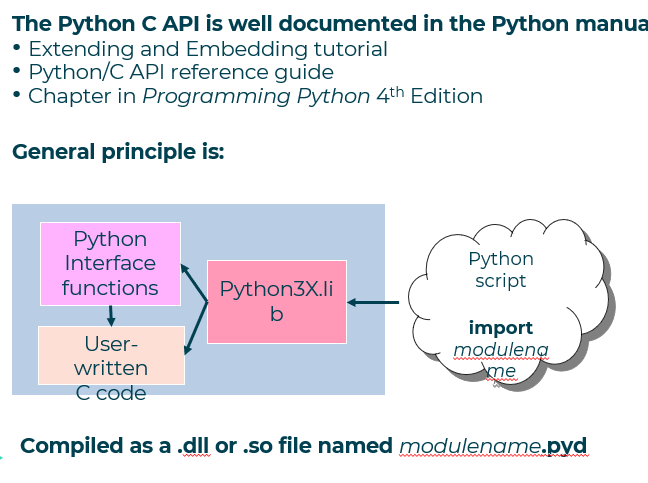

A Windows DLL or UNIX .so file is created as a .pyd file

In the C source code:
#include <Python.h>
Describe the module
Describe the C functions with their Python names
Create a module initialisation function

The simplest way to build is using distutils
Includes the correct directories and libraries

In the Python code just import the module as normal
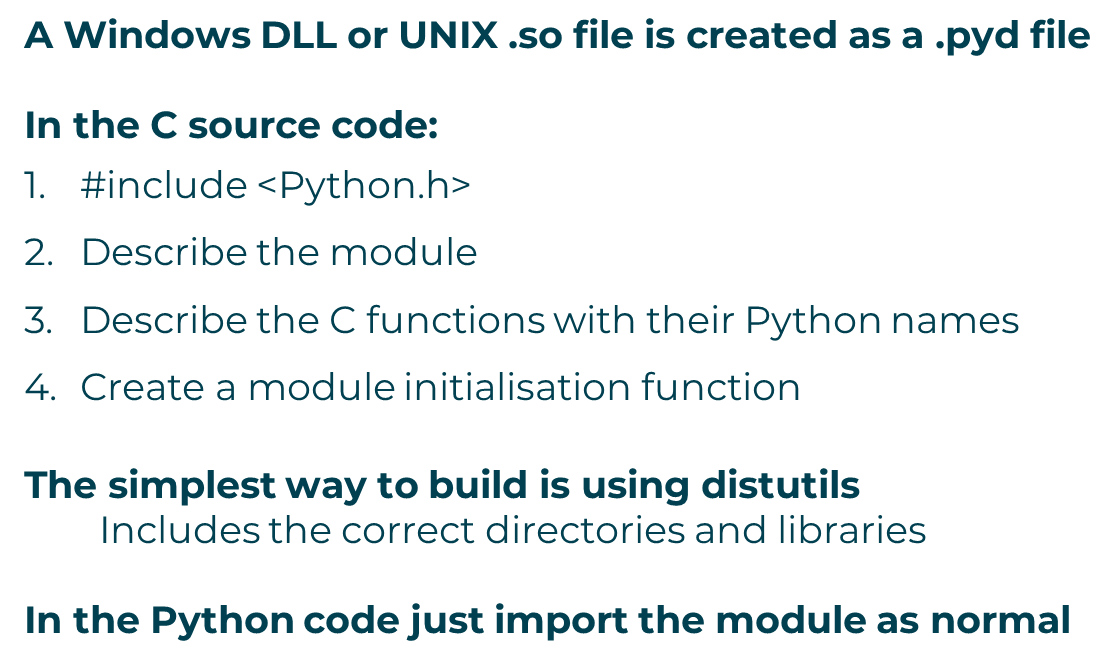

Creating a new module
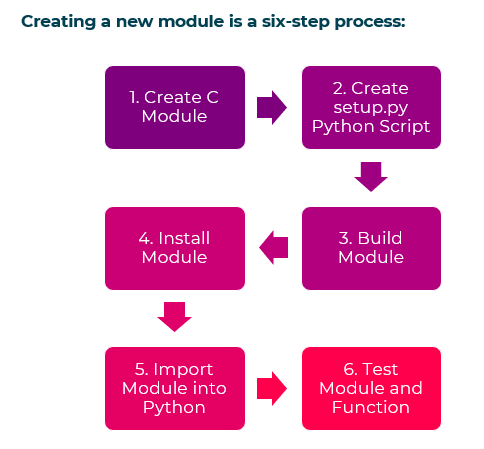

In [ ]:
# c file 
#include <Python.h>


PyObject * Hello(PyObject *, PyObject *); # prototype

static PyMethodDef SimpleMethods[] = {
    {"Hello", Hello, METH_NOARGS, "Says Hello World!"},
    {NULL, NULL, 0, NULL}
}; # Method registration table


static struct PyModuleDef Simple_module = {
   PyModuleDef_HEAD_INIT,
   "Simple",   
   "Test Module",
   -1,       
   SimpleMethods
};

PyMODINIT_FUNC PyInit_Simple(void)
{
    return PyModule_Create(&Simple_module);
}

static PyObject * Hello(PyObject *self, PyObject *args)
{
    printf("Hello, World!\n");
    return Py_None;
}



The above is a simple module called simple, you can see the PyModDef that describes the module.
And the name of the array of PyMethodDef structs that describes the methods 

In [ ]:
# setup.py file

from distutils.core import setup, Extension

my_module = Extension("simple", sources=['simple.c'])

setup(
    name="simple",
    version = "0.1dev",
    description = "This is a test package",
    author = "dev guy",
    url = "https://qa.com",
    ext_modules = [my_module])


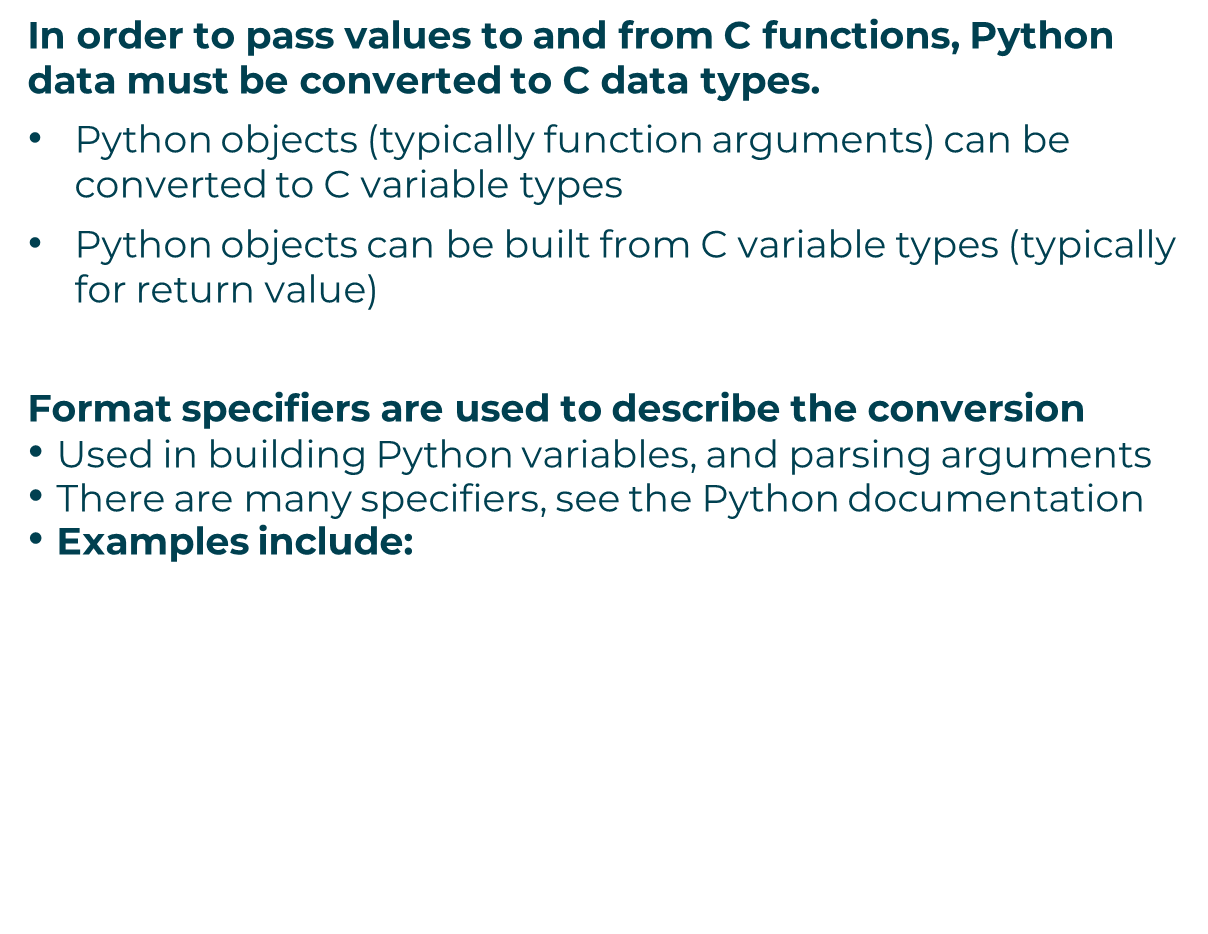


If it is required for us to pass parameters from python to C then the calling convention needs to be specified in the method table

METH_NOARGS
no parameters fast 

METH_VARGS

The calling convention is specified in the PyMethodDef struct for each callable C function.  METH_VARARGS is the most common calling convention,  we shall see some of the others later.
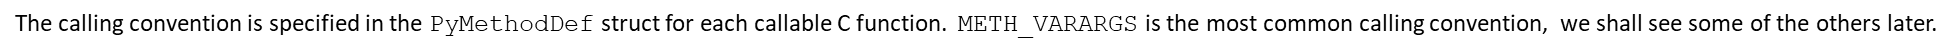


For an exception to be detected and raised by Python, the C function must return NULL, or -1 if the function returned any type of signed int.

On Windows there are (at least) two types of errors, those from the C run-time library that use errno and strerror(), and those from the Win32 API that use GetLastError() and FormatMessage().  

The Errno exceptions can be used with errno on Windows, but for Win32 API errors use one of: 

PyErr_SetFromWindowsErr()
PyErr_SetExcFromWindowsErr() 
PyErr_SetFromWindowsErrWithFilename()
PyErr_SetExcFromWindowsErrWithFilename()


Let's add a second function to the "simple" module which:
Accepts an argument
(Returns an error if no argument used in the function call)
Returns a value

Let's keep things relatively simple:

int ---> cubeit() ----> int


This will mean modifying "simple.c" by:
Creating a new function declaration for cubeit()
Adding an entry for cubeit into the MRT (Method Registration Table)

Once completed we can simply rebuild and then re-install.
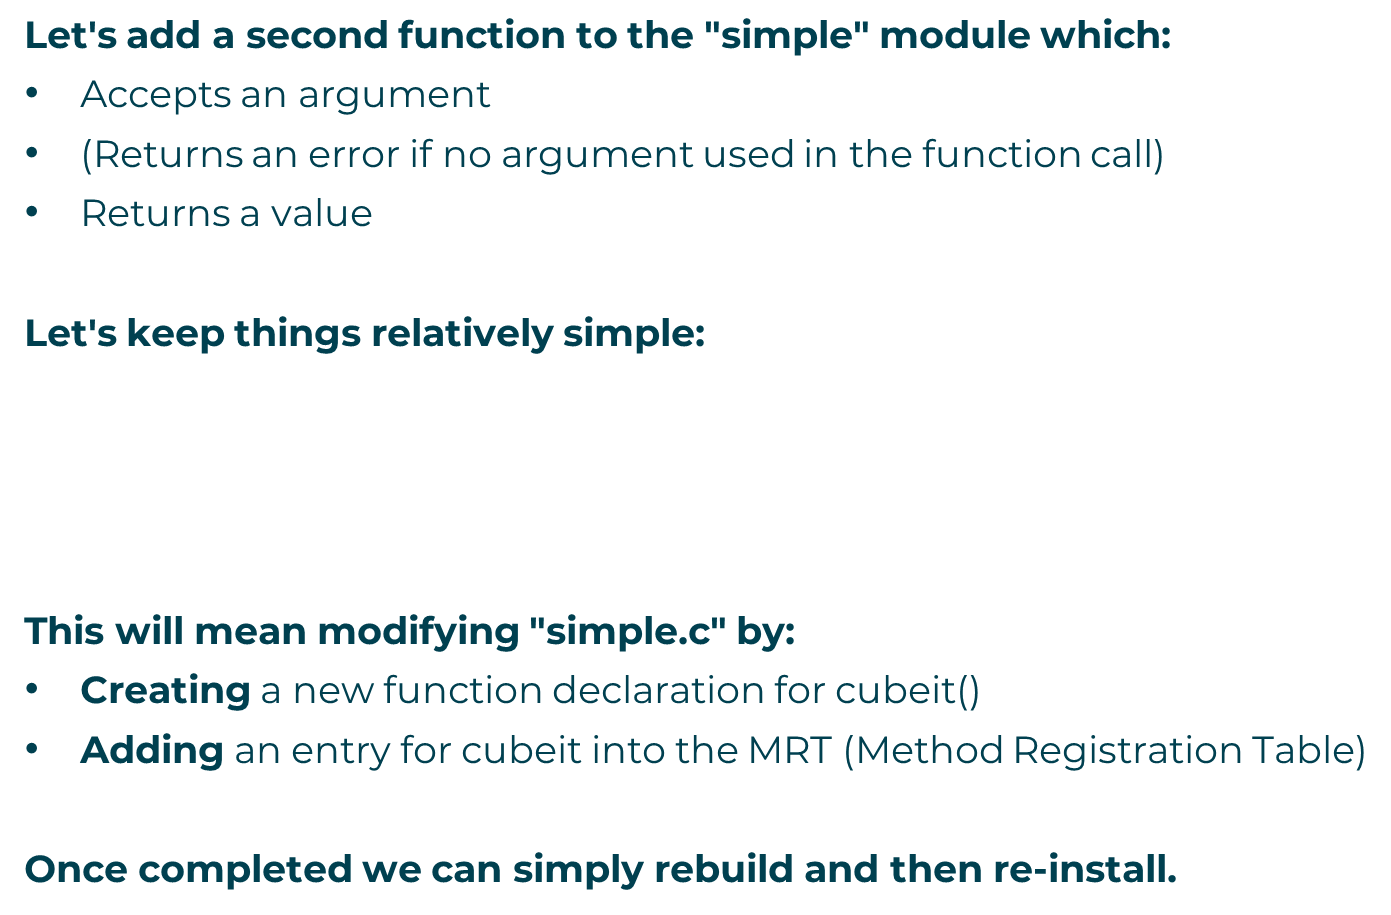



In [ ]:
static PyObject * cubeit(PyObject * self, PyObject * args)
{
    int cubed_val;
    
    //check if there's an integer argument passed in
    if(!PyArg_ParseTuple(args, "i", &cuged_val))
    {
        //no, then abort
        return NULL;
    }
    
    cubed_val = cubed_val * cubed_val * cubed_val;
    
    return PyBuildValue("i", cubed_val);
}


//WRT (Method Resolution Table)
static PyMethodDef simpleMethods[] = 
{
    {"helloworld", helloworld, METH_NOARGS, "Prints Hellow, world!"},
    {"cubeit", cubeit, METH_VARARGS, "Returns the cube of a number"},
    {NULL, NULL, 0, NULL}
};


Reference counts are useful in Python when writing a C module because they allow the C code to keep track of how many references are pointing to a particular object. This is important because it allows the C code to properly manage the memory associated with the object, and to ensure that the object is properly freed when it is no longer needed. Reference counts also help to prevent memory leaks, which can cause a program to become unstable or crash.

### METH_O
Base object types and macros`
All Python objects ultimately share a small number of fields at the beginning of the object’s representation in memory. These are represented by the PyObject and PyVarObject types, which are defined, in turn, by the expansions of some macros also used, whether directly or indirectly, in the definition of all other Python objects.

## Sentinal in the MRT
In the MRT there is a sentinal, a  sentinel is a special element that marks the end of the list of methods associated with a Python extension type. It's a way to tell the Python runtime when it has reached the last valid method definition.

Here's a breakdown of how the sentinel works:

PyMethodDef Structure:  This structure defines a method for a Python extension type. It typically includes fields like:

char *name: The name of the method exposed to Python.
PyCFunction func: A pointer to the C function implementing the method logic.
int ml_flags: Flags specifying method behavior (e.g., method with variable arguments).
char *doc: Docstring for the method (optional).
Array of PyMethodDef: When defining multiple methods for a type, you create an array of PyMethodDef structures. Each element in the array represents a single method.

Sentinel Element: The last element in this array serves as the sentinel. It's a PyMethodDef structure with all its fields set to NULL. This tells the Python runtime that there are no more methods defined after this point.

In [ ]:
static PyMethodDef MyType_methods[] = {
  {"method1",  MyType_method1, METH_VARARGS, "Docstring for method1"},
  {"method2",  MyType_method2, METH_NOARGS, "Docstring for method2"},
  {NULL, NULL, 0, NULL}  // Sentinel element
};
